In [51]:
import pandas as pd
#pip install prophet
#pip install ipywidgets
from prophet import Prophet
import itertools
import numpy as np

# import sys
# sys.path.append('/Users/thomas_metral/code/thomas-metral/metro_seoul')
# print(sys.path)


from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns
from metro_app.ml_logic.preprocess import general_preprocessing, model_data_preprocessing, preprocess_lstm, prophet_preprocessing_one_station

from metro_app.ml_logic.model import train_prophet, predict_prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error
import datetime


## Import and preprocess

In [7]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_63338/931817464.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


In [4]:
df_achasan5 = prophet_preprocessing_one_station(df=df, station_name="Achasan(Rear Entrance to Seoul Children's Grand Park)",
                                       metro_line=5, entry_exit='exit')


/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line'] = df['line'].astype('int')
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

## Train/Test split

In [80]:
#lenght of test data
days = 2

# index = round(train_size*df_156.shape[0])
df_achasan5_train = df_achasan5.iloc[:-24*days]
df_achasan5_test = df_achasan5.iloc[-24*days:]

#shorten the train data
df_achasan5_train = df_achasan5_train.iloc[-24*500:]


## Adding columns for regressor

In [90]:
df_achasan5_train['is_morning_peak'] = ((df_achasan5_train['ds'].dt.hour == 8) & (df_achasan5_train['ds'].dt.dayofweek <= 5)).astype(int)
df_achasan5_train['is_afternoon_peak'] = ((df_achasan5_train['ds'].dt.hour == 18) & (df_achasan5_train['ds'].dt.dayofweek <= 5)).astype(int)
df_achasan5_train['is_closed'] = ((df_achasan5_train['ds'].dt.hour >= 0) & (df_achasan5_train['ds'].dt.hour <= 4)).astype(int)
df_achasan5_train['is_weekend'] = (df_achasan5_train['ds'].dt.dayofweek >= 5).astype(int)
df_achasan5_train.sample(18)


,ds,y,is_morning_peak,is_afternoon_peak,is_closed,is_weekend
23988,2022-09-26 13:00:00,603.0,0,0,0,0
18771,2022-02-21 04:00:00,0.0,0,0,1,0
19250,2022-03-13 03:00:00,0.0,0,0,1,1
19890,2022-04-08 19:00:00,1520.0,0,0,0,0
23365,2022-08-31 14:00:00,501.0,0,0,0,0
22607,2022-07-31 00:00:00,0.0,0,0,1,1
25551,2022-11-30 16:00:00,941.0,0,0,0,0
26092,2022-12-23 05:00:00,46.0,0,0,0,0
24934,2022-11-04 23:00:00,447.0,0,0,0,0
23087,2022-08-20 00:00:00,0.0,0,0,1,1


## Train/Predict

In [91]:
model = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=12.0,
                  holidays_prior_scale=10.0, seasonality_mode='multiplicative', daily_seasonality=True)
model.add_regressor('is_morning_peak')
model.add_regressor('is_afternoon_peak')
model.add_regressor('is_closed')
model.add_seasonality('daily', period=24, fourier_order=2)
model.add_country_holidays(country_name='SK')

model.fit(df_achasan5_train)


# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

# Generate predictions
forecast = model.predict(future)
prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


14:59:56 - cmdstanpy - INFO - Chain [1] start processing
14:59:56 - cmdstanpy - INFO - Chain [1] done processing


## Check results

0.43058828484551587

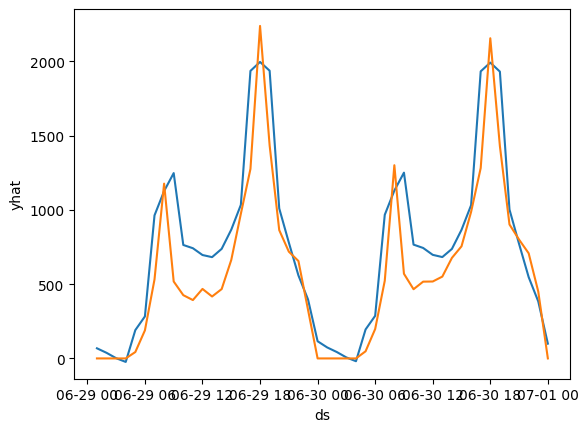

In [92]:
sns.lineplot(x=prediction['ds'], y=prediction['yhat'])
sns.lineplot(x=df_achasan5_test['ds'], y=df_achasan5_test['y'])

mape(prediction['yhat'].values, df_achasan5_test['y'].values)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


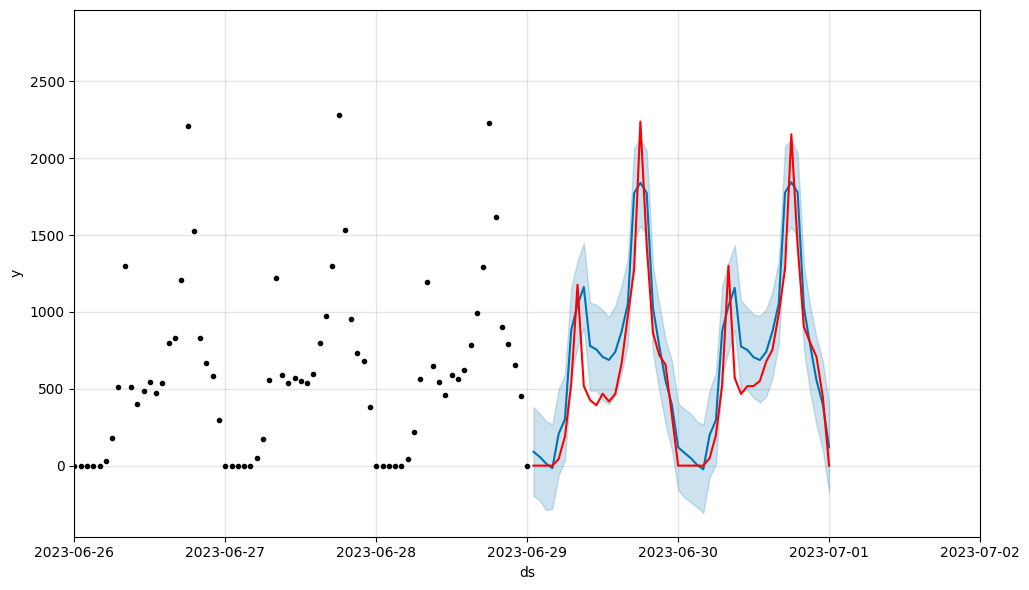

In [55]:
ax = model.plot(forecast)
plt.plot(df_achasan5_test['ds'],df_achasan5_test['y'],'r')
plt.xlim(left=(pd.Timestamp(max(df_achasan5.ds)-datetime.timedelta(days=5))),
right=(pd.Timestamp(max(df_achasan5.ds)+ datetime.timedelta(days=1)))
)
plt.show()


### Cross Validation with grid search

In [34]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003],
    'seasonality_prior_scale': [10.0, 12.0, 20.0],
    'holidays_prior_scale' : [9.0, 10.0, 15.0],
    'seasonality_mode' : ['multiplicative']

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='KR')
    m.add_regressor('is_morning_peak')
    m.add_regressor('is_afternoon_peak')
    m.add_regressor('is_closed')
    m.fit(df_achasan5_train)
    df_cv = cross_validation(m, initial='400 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
tuning_results.iloc[rmses.index(min(rmses))]


14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:01 - cmdstanpy - INFO - Chain [1] start processing
14:14:02 - cmdstanpy - INFO - Chain [1] done processing
14:14:02 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:04 - cmdstanpy - INFO - Chain [1] start processing
14:14:04 - cmdstanpy - INFO - Chain [1] done processing
14:14:05 - cmdstanpy - INFO - Chain [1] start processing
14:14:05 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:08 - cmdstanpy - INFO - Chain [1] done processing
14:14:08 - cmdstanpy - INFO - Chain [1] start processing
14:14:09 - cmdstanpy - INFO - Chain [1] done processing
14:14:09 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     10.0                   9.0   
1                     0.001                     10.0                  10.0   
2                     0.001                     10.0                  15.0   
3                     0.001                     12.0                   9.0   
4                     0.001                     12.0                  10.0   
5                     0.001                     12.0                  15.0   
6                     0.001                     20.0                   9.0   
7                     0.001                     20.0                  10.0   
8                     0.001                     20.0                  15.0   
9                     0.002                     10.0                   9.0   
10                    0.002                     10.0                  10.0   
11                    0.002                     10.0            

14:15:14 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale             0.003
seasonality_prior_scale              12.0
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
rmse                           159.299028
Name: 22, dtype: object

In [35]:

np.sqrt(mean_squared_error(prediction['yhat'].values, df_achasan5_test['y'].values))


251.06858634542422

In [36]:
df_p


,horizon,mse,rmse,mae,mdape,smape,coverage
0,2 days,26063.986303,161.443446,125.170957,0.217973,0.604893,0.895833
